# Kernel Comparison for KLRfome

This notebook compares different kernel approaches for distribution regression in KLRfome.

## Available Kernels

| Kernel | `kernel_type` | Description | Best For |
|--------|--------------|-------------|----------|
| **Mean Embedding** | `'mean_embedding'` | Similarity via inner product of mean embeddings in RKHS | Distributions that differ by location/mean |
| **Wasserstein** | `'wasserstein'` | RBF kernel on Sliced Wasserstein distance | Distributions with similar means but different shapes |

This notebook is designed to be extended as new kernels are added.


In [1]:
import sys
sys.path.insert(0, '..')

import jax.numpy as jnp
import jax.random as random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import rasterio
import rasterio.transform
from rasterio.transform import from_bounds
import geopandas as gpd
from shapely.geometry import Point
import time
from dataclasses import dataclass
from typing import Dict, List, Callable

from klrfome import KLRfome, RasterStack, TrainingData, SampleCollection
from klrfome.data.simulation import sim_trend, rescale_sim_raster, nlm_gaussianfield
from klrfome.visualization import plot_predictions

print("KLRfome Kernel Comparison Notebook")
print("=" * 40)

KLRfome Kernel Comparison Notebook


## 1. Define Kernel Configurations

Each kernel configuration is defined as a dictionary. Add new kernels here as they become available.


In [2]:
# Define kernel configurations to compare
# Add new kernels here as they become available

KERNEL_CONFIGS = {
    'Mean Embedding (RFF)': {
        'kernel_type': 'mean_embedding',
        'n_rff_features': 256,
        'description': 'Mean embedding with Random Fourier Features approximation',
        'color': '#2E86AB'  # Blue
    },
    'Mean Embedding (Exact)': {
        'kernel_type': 'mean_embedding',
        'n_rff_features': 0,
        'description': 'Mean embedding with exact kernel computation',
        'color': '#1B4965'  # Dark blue
    },
    'Wasserstein (p=2)': {
        'kernel_type': 'wasserstein',
        'n_projections': 100,
        'wasserstein_p': 2,
        'description': 'Sliced Wasserstein kernel with p=2 (Euclidean)',
        'color': '#A23B72'  # Magenta
    },
    'Wasserstein (p=1)': {
        'kernel_type': 'wasserstein',
        'n_projections': 100,
        'wasserstein_p': 1,
        'description': 'Sliced Wasserstein kernel with p=1 (Manhattan)',
        'color': '#F18F01'  # Orange
    },
    # Add new kernels here:
    # 'New Kernel': {
    #     'kernel_type': 'new_kernel_type',
    #     'param': value,
    #     'description': 'Description of new kernel',
    #     'color': '#HEXCODE'
    # },
}

print(f"Comparing {len(KERNEL_CONFIGS)} kernel configurations:")
for name, config in KERNEL_CONFIGS.items():
    print(f"  - {name}: {config['description']}")


Comparing 4 kernel configurations:
  - Mean Embedding (RFF): Mean embedding with Random Fourier Features approximation
  - Mean Embedding (Exact): Mean embedding with exact kernel computation
  - Wasserstein (p=2): Sliced Wasserstein kernel with p=2 (Euclidean)
  - Wasserstein (p=1): Sliced Wasserstein kernel with p=1 (Manhattan)


## 2. Data Generation with Difficulty Levels

We use realistic spatial data generation (same as 01_quickstart) with configurable difficulty levels.

**Key Parameters:**
- `mix_strength`: Controls overlap between site/background conditions (lower = harder)
- `trend_power`: Controls concentration of favorable areas (higher = more concentrated)
- `favor_threshold`: Sites placed in bottom X% of favorability
- `noise_level`: Random noise added to features

**Difficulty Presets:**
- **Easy**: High signal, low noise (AUC ~0.9)
- **Medium**: Moderate signal and noise (AUC ~0.7-0.8)
- **Hard**: Low signal, high noise (AUC ~0.6-0.7)

In [3]:
def generate_realistic_scenario(
    difficulty='medium',
    cols=100,
    rows=100,
    n_sites=20,
    n_features=3,
    autocorr_range=15,
    seed=42
):
    """Generate realistic spatial data with controlled difficulty.
    
    Returns:
        raster_stack: RasterStack with spatially autocorrelated features
        sites_gdf: GeoDataFrame with site locations
        transform: Rasterio affine transform
    """
    # Difficulty parameter presets
    difficulty_params = {
        'easy': {
            'mix_strength': 0.5,
            'trend_power': 1.5,
            'favor_threshold': 0.6,
            'noise_level': 0.05
        },
        'medium': {
            'mix_strength': 0.3,
            'trend_power': 1.0,
            'favor_threshold': 0.5,
            'noise_level': 0.15
        },
        'hard': {
            'mix_strength': 0.2,
            'trend_power': 0.7,
            'favor_threshold': 0.4,
            'noise_level': 0.25
        }
    }
    params = difficulty_params[difficulty]
    
    # Step 1: Create site-likely rasters (conditions favorable for sites)
    s_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=seed)
    vars_site = []
    scales = [(60, 15), (4, 2), (6, 1.5)]  # (mean, sd) for each feature
    for i in range(n_features):
        if i < len(scales):
            vars_site.append(rescale_sim_raster(s_var1r, scales[i][0], scales[i][1]))
        else:
            vars_site.append(rescale_sim_raster(s_var1r, 50, 10))
    
    # Step 2: Create site-unlikely rasters (background conditions)
    b_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=seed + 1000)
    vars_bg = []
    bg_scales = [(80, 15), (5, 2), (8, 1.5)]
    for i in range(n_features):
        if i < len(bg_scales):
            vars_bg.append(rescale_sim_raster(b_var1r, bg_scales[i][0], bg_scales[i][1]))
        else:
            vars_bg.append(rescale_sim_raster(b_var1r, 70, 10))
    
    # Step 3: Place sites in favorable areas
    favorability_surface = s_var1r
    trend_result = sim_trend(
        cols, rows,
        n=n_sites,
        size=6,
        seed=seed,
        favorable_surface=favorability_surface,
        favor_threshold=params['favor_threshold']
    )
    trend = trend_result['trend']
    site_coords_pixels = trend_result['coords']
    
    # Step 4: Apply trend power
    trend = np.power(trend, params['trend_power'])
    inv_trend = 1 - trend
    
    # Step 5: Combine rasters with controlled mixing
    combined_vars = []
    for i in range(n_features):
        mix = params['mix_strength']
        combined = (vars_site[i] * (trend * mix + (1 - mix) * 0.5)) + \
                   (vars_bg[i] * (inv_trend * mix + (1 - mix) * 0.5))
        combined_vars.append(combined)
    
    # Step 6: Add random noise
    np.random.seed(seed)
    for i in range(n_features):
        noise = np.random.normal(0, params['noise_level'] * np.std(combined_vars[i]), 
                                combined_vars[i].shape)
        combined_vars[i] = combined_vars[i] + noise
    
    # Step 7: Create RasterStack
    data = jnp.array(combined_vars)
    transform = from_bounds(0, 0, 1, 1, cols, rows)
    band_names = [f'var{i+1}' for i in range(n_features)]
    
    raster_stack = RasterStack(
        data=data,
        transform=transform,
        crs="EPSG:4326",
        band_names=band_names
    )
    
    # Step 8: Convert pixel coordinates to geographic coordinates
    site_points = []
    for coord in site_coords_pixels:
        # sim_trend returns (col, row), transform.xy expects (row, col)
        x, y = rasterio.transform.xy(transform, coord[1], coord[0])
        site_points.append(Point(x, y))
    
    sites_gdf = gpd.GeoDataFrame(geometry=site_points, crs=raster_stack.crs)
    
    return raster_stack, sites_gdf, transform


# Define scenarios to test
SCENARIOS = [
    {
        'name': 'Easy',
        'difficulty': 'easy',
        'description': 'High signal, low noise. Strong separation expected.',
        'expected_range': (0.85, 0.95)
    },
    {
        'name': 'Medium',
        'difficulty': 'medium',
        'description': 'Moderate signal and noise. Realistic challenge.',
        'expected_range': (0.70, 0.85)
    },
    {
        'name': 'Hard',
        'difficulty': 'hard',
        'description': 'Low signal, high noise. Challenging separation.',
        'expected_range': (0.60, 0.75)
    }
]

print(f"Defined {len(SCENARIOS)} test scenarios:")
for s in SCENARIOS:
    print(f"  - {s['name']}: {s['description']}")
    print(f"    Expected AUC: {s['expected_range'][0]:.2f}-{s['expected_range'][1]:.2f}")

Defined 3 test scenarios:
  - Easy: High signal, low noise. Strong separation expected.
    Expected AUC: 0.85-0.95
  - Medium: Moderate signal and noise. Realistic challenge.
    Expected AUC: 0.70-0.85
  - Hard: Low signal, high noise. Challenging separation.
    Expected AUC: 0.60-0.75


## 2a. Configuration Parameters

**IMPORTANT:** All key parameters are set here for easy modification.

In [4]:
################################################################################
# CONFIGURATION PARAMETERS - EDIT HERE
################################################################################

# Data generation parameters
DIFFICULTY = 'hard'        # 'easy', 'medium', 'hard'
N_SITES = 75                 # Total number of sites to generate
N_FEATURES = 3               # Number of environmental features
RASTER_COLS = 250            # Raster width
RASTER_ROWS = 250            # Raster height
SEED = 4256                    # Random seed for reproducibility

# Train/test split
TEST_SIZE = 0.4              # Fraction of sites for testing (0.2 = 20%)
SPLIT_RANDOM_STATE = 42      # Random seed for train/test split

# Sampling parameters
SAMPLES_PER_SITE = 25        # Number of unique samples to extract per site
N_BACKGROUND_TRAIN = 50      # Number of background distributions for training
N_BACKGROUND_TEST = 50       # Number of background distributions for testing
SITE_BUFFER = 0.05           # Buffer radius around site centroid for sampling (0.05 = ~7.5 pixels)
BACKGROUND_BUFFER = 0.03     # Buffer radius around background points for sampling (0.03 = ~4.5 pixels)
BACKGROUND_EXCLUSION = 0.07  # Exclusion buffer around ALL sites for background (0.07 = ~10.5 pixels)

# Model parameters
SIGMA = 0.5                  # RBF kernel bandwidth
LAMBDA_REG = 0.1             # Regularization parameter

print("="*80)
print("CONFIGURATION LOADED")
print("="*80)
print(f"Data generation:")
print(f"  Difficulty: {DIFFICULTY}")
print(f"  Total sites: {N_SITES}")
print(f"  Features: {N_FEATURES}")
print(f"  Raster size: {RASTER_ROWS}x{RASTER_COLS}")
print(f"\nTrain/Test split:")
print(f"  Test size: {TEST_SIZE*100:.0f}%")
print(f"  Expected train sites: {int(N_SITES * (1-TEST_SIZE))}")
print(f"  Expected test sites: {int(N_SITES * TEST_SIZE)}")
print(f"\nSampling (CRITICAL FOR JIT):")
print(f"  Samples per site: {SAMPLES_PER_SITE} (EXACT - no variation allowed)")
print(f"  Background (train): {N_BACKGROUND_TRAIN}")
print(f"  Background (test): {N_BACKGROUND_TEST}")
print(f"  Site buffer: {SITE_BUFFER} (≈{SITE_BUFFER*RASTER_COLS:.1f} pixels)")
print(f"  Background buffer: {BACKGROUND_BUFFER} (≈{BACKGROUND_BUFFER*RASTER_COLS:.1f} pixels)")
print(f"  Background exclusion: {BACKGROUND_EXCLUSION} (≈{BACKGROUND_EXCLUSION*RASTER_COLS:.1f} pixels)")
print(f"\nNote: Each pixel = {1/RASTER_COLS:.4f} geographic units")
print(f"      ALL collections MUST have exactly {SAMPLES_PER_SITE} samples for JIT optimization")
print(f"      Larger background buffer ensures sufficient samples available")
print("="*80)

CONFIGURATION LOADED
Data generation:
  Difficulty: hard
  Total sites: 75
  Features: 3
  Raster size: 250x250

Train/Test split:
  Test size: 40%
  Expected train sites: 45
  Expected test sites: 30

Sampling (CRITICAL FOR JIT):
  Samples per site: 25 (EXACT - no variation allowed)
  Background (train): 50
  Background (test): 50
  Site buffer: 0.05 (≈12.5 pixels)
  Background buffer: 0.03 (≈7.5 pixels)
  Background exclusion: 0.07 (≈17.5 pixels)

Note: Each pixel = 0.0040 geographic units
      ALL collections MUST have exactly 25 samples for JIT optimization
      Larger background buffer ensures sufficient samples available


In [5]:
def generate_realistic_scenario(
    difficulty='medium',
    cols=100,
    rows=100,
    n_sites=20,
    n_features=3,
    autocorr_range=15,
    seed=42
):
    """Generate realistic spatial data with controlled difficulty.
    
    Returns:
        raster_stack: RasterStack with spatially autocorrelated features
        sites_gdf: GeoDataFrame with site locations
        transform: Rasterio affine transform
    """
    # Difficulty parameter presets
    difficulty_params = {
        'easy': {
            'mix_strength': 0.5,
            'trend_power': 1.5,
            'favor_threshold': 0.6,
            'noise_level': 0.05
        },
        'medium': {
            'mix_strength': 0.3,
            'trend_power': 1.0,
            'favor_threshold': 0.5,
            'noise_level': 0.15
        },
        'hard': {
            'mix_strength': 0.2,
            'trend_power': 0.7,
            'favor_threshold': 0.4,
            'noise_level': 0.25
        }
    }
    params = difficulty_params[difficulty]
    
    # Step 1: Create site-likely rasters (conditions favorable for sites)
    s_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=seed)
    vars_site = []
    scales = [(60, 15), (4, 2), (6, 1.5)]  # (mean, sd) for each feature
    for i in range(n_features):
        if i < len(scales):
            vars_site.append(rescale_sim_raster(s_var1r, scales[i][0], scales[i][1]))
        else:
            vars_site.append(rescale_sim_raster(s_var1r, 50, 10))
    
    # Step 2: Create site-unlikely rasters (background conditions)
    b_var1r = nlm_gaussianfield(cols, rows, autocorr_range=autocorr_range, seed=seed + 1000)
    vars_bg = []
    bg_scales = [(80, 15), (5, 2), (8, 1.5)]
    for i in range(n_features):
        if i < len(bg_scales):
            vars_bg.append(rescale_sim_raster(b_var1r, bg_scales[i][0], bg_scales[i][1]))
        else:
            vars_bg.append(rescale_sim_raster(b_var1r, 70, 10))
    
    # Step 3: Place sites in favorable areas
    favorability_surface = s_var1r
    trend_result = sim_trend(
        cols, rows,
        n=n_sites,
        size=6,
        seed=seed,
        favorable_surface=favorability_surface,
        favor_threshold=params['favor_threshold']
    )
    trend = trend_result['trend']
    site_coords_pixels = trend_result['coords']
    
    # Step 4: Apply trend power
    trend = np.power(trend, params['trend_power'])
    inv_trend = 1 - trend
    
    # Step 5: Combine rasters with controlled mixing
    combined_vars = []
    for i in range(n_features):
        mix = params['mix_strength']
        combined = (vars_site[i] * (trend * mix + (1 - mix) * 0.5)) + \
                   (vars_bg[i] * (inv_trend * mix + (1 - mix) * 0.5))
        combined_vars.append(combined)
    
    # Step 6: Add random noise
    np.random.seed(seed)
    for i in range(n_features):
        noise = np.random.normal(0, params['noise_level'] * np.std(combined_vars[i]), 
                                combined_vars[i].shape)
        combined_vars[i] = combined_vars[i] + noise
    
    # Step 7: Create RasterStack
    data = jnp.array(combined_vars)
    transform = from_bounds(0, 0, 1, 1, cols, rows)
    band_names = [f'var{i+1}' for i in range(n_features)]
    
    raster_stack = RasterStack(
        data=data,
        transform=transform,
        crs="EPSG:4326",
        band_names=band_names
    )
    
    # Step 8: Convert pixel coordinates to geographic coordinates
    site_points = []
    for coord in site_coords_pixels:
        # sim_trend returns (col, row), transform.xy expects (row, col)
        x, y = rasterio.transform.xy(transform, coord[1], coord[0])
        site_points.append(Point(x, y))
    
    sites_gdf = gpd.GeoDataFrame(geometry=site_points, crs=raster_stack.crs)
    
    return raster_stack, sites_gdf, transform

print("Data generation function defined!")

Data generation function defined!


In [6]:
from sklearn.metrics import confusion_matrix, f1_score

@dataclass
class KernelResult:
    """Results from evaluating a kernel on a dataset."""
    kernel_name: str
    # Test set metrics
    auc: float
    sensitivity: float
    specificity: float
    f1: float
    youdens_j: float
    optimal_threshold: float
    # Training set metrics
    train_auc: float
    train_sensitivity: float
    train_specificity: float
    train_f1: float
    # Timing
    fit_time: float
    predict_time: float
    # Convergence
    converged: bool
    n_iterations: int
    # Predictions
    train_predictions: np.ndarray
    train_labels: np.ndarray
    test_predictions: np.ndarray
    test_labels: np.ndarray
    raster_predictions: np.ndarray = None

print("KernelResult dataclass defined!")

KernelResult dataclass defined!


In [7]:
def extract_unique_samples_per_site(raster_stack, site_geom, transform,
                                    samples_per_site=25, buffer_radius=0.01, seed=None):
    """Extract UNIQUE raster cells for one site (no duplicate pixels).
    
    CRITICAL: Returns EXACTLY samples_per_site samples, or raises ValueError.
    This ensures uniform sample sizes for JIT-optimized Wasserstein prediction.

    Args:
        raster_stack: RasterStack to sample from
        site_geom: Shapely geometry for the site (Point)
        transform: Rasterio affine transform
        samples_per_site: Number of unique samples to extract (EXACT)
        buffer_radius: Buffer radius around site centroid
        seed: Random seed for sampling (optional)

    Returns:
        samples: Array of shape (samples_per_site, n_features) with unique pixel values
        
    Raises:
        ValueError: If fewer than samples_per_site unique cells available
    """
    if seed is not None:
        np.random.seed(seed)

    # Get site centroid
    site_point = site_geom if site_geom.geom_type == 'Point' else site_geom.centroid

    # Create buffer for bounding box calculation
    site_buffer = site_point.buffer(buffer_radius)
    minx, miny, maxx, maxy = site_buffer.bounds

    # Get pixel range that could contain points within buffer
    row_min, col_min = rasterio.transform.rowcol(transform, minx, maxy)
    row_max, col_max = rasterio.transform.rowcol(transform, maxx, miny)

    # Collect ALL candidate cells within buffer using DISTANCE check
    candidate_cells = []
    for row in range(max(0, row_min), min(raster_stack.data.shape[1], row_max + 1)):
        for col in range(max(0, col_min), min(raster_stack.data.shape[2], col_max + 1)):
            # Get pixel center coordinates
            x, y = rasterio.transform.xy(transform, row, col, offset='center')
            point = Point(x, y)

            # Check distance from site (includes boundary points)
            if site_point.distance(point) <= buffer_radius:
                # Extract feature vector from this unique cell
                features = np.array(raster_stack.data[:, row, col])
                candidate_cells.append((row, col, features))

    # CRITICAL: Require EXACTLY samples_per_site samples for JIT optimization
    if len(candidate_cells) < samples_per_site:
        # Calculate pixel size for error message
        pixel_width = abs(transform.a)
        pixel_height = abs(transform.e)
        raise ValueError(
            f"Insufficient samples: {len(candidate_cells)} < {samples_per_site} required\n"
            f"  Location: ({site_point.x:.4f}, {site_point.y:.4f})\n"
            f"  Buffer radius: {buffer_radius:.4f}\n"
            f"  Pixel size: {pixel_width:.4f} × {pixel_height:.4f}\n"
            f"  Try increasing buffer radius to at least {pixel_width * 6:.4f}"
        )

    # Random sample without replacement (EXACTLY samples_per_site)
    indices = np.random.choice(len(candidate_cells),
                               size=samples_per_site,
                               replace=False)
    selected = [candidate_cells[i] for i in indices]

    # Return feature vectors only (drop row/col indices)
    samples = np.array([cell[2] for cell in selected])
    
    # Verify we have exactly the right number
    assert samples.shape[0] == samples_per_site, f"Got {samples.shape[0]} samples, expected {samples_per_site}"
    
    return samples


def extract_background_samples(raster_stack, all_sites_gdf, transform,
                               n_background=50, samples_per_location=25,
                               exclusion_buffer=0.02, background_buffer=0.03,
                               seed=42, max_attempts_multiplier=500):
    """Extract background samples EXCLUDING ALL site areas.
    
    CRITICAL: Only returns locations with EXACTLY samples_per_location samples.
    This ensures uniform sample sizes for JIT-optimized Wasserstein prediction.
    
    Args:
        raster_stack: RasterStack to sample from
        all_sites_gdf: GeoDataFrame with ALL sites (train + test)
        transform: Rasterio affine transform
        n_background: Number of background distributions to create
        samples_per_location: Samples per background distribution (EXACT)
        exclusion_buffer: Buffer radius around ALL sites to exclude
        background_buffer: Buffer radius for sampling around background point
        seed: Random seed
        max_attempts_multiplier: Max attempts = n_background * this value
        
    Returns:
        background_collections: List of SampleCollection objects (label=0)
                                All with EXACTLY samples_per_location samples
    """
    np.random.seed(seed)
    
    # Create combined exclusion zone from ALL sites
    all_exclusion = all_sites_gdf.buffer(exclusion_buffer).unary_union
    
    # Sample random locations outside exclusion zone
    rows, cols = raster_stack.data.shape[1:]
    background_collections = []
    attempts = 0
    max_attempts = n_background * max_attempts_multiplier
    
    while len(background_collections) < n_background and attempts < max_attempts:
        attempts += 1
        
        # Random pixel location
        row = np.random.randint(0, rows)
        col = np.random.randint(0, cols)
        x, y = rasterio.transform.xy(transform, row, col, offset='center')
        point = Point(x, y)
        
        # Check if outside exclusion zone
        if not all_exclusion.contains(point):
            # Extract unique samples around this location
            try:
                samples = extract_unique_samples_per_site(
                    raster_stack, point, transform, 
                    samples_per_site=samples_per_location,
                    buffer_radius=background_buffer,  # Use larger buffer for background
                    seed=None  # Let numpy's current state determine randomness
                )
                
                # Verify exact size (should be guaranteed by extract function)
                assert samples.shape[0] == samples_per_location
                
                # Successfully got EXACTLY samples_per_location samples
                background_collections.append(
                    SampleCollection(
                        samples=jnp.array(samples),
                        label=0,  # Background
                        id=f"bg_{len(background_collections)}",
                        metadata={'location': (x, y)}
                    )
                )
            except (ValueError, AssertionError):
                # Location doesn't have enough samples - skip and try another
                continue
    
    if len(background_collections) < n_background:
        print(f"  Warning: Only extracted {len(background_collections)} background locations (requested {n_background})")
        print(f"          Consider increasing background_buffer or reducing n_background")
    
    # Final verification: ALL collections have same size
    sample_sizes = [len(c.samples) for c in background_collections]
    assert len(set(sample_sizes)) == 1, f"Non-uniform sample sizes: {set(sample_sizes)}"
    assert sample_sizes[0] == samples_per_location, f"Expected {samples_per_location}, got {sample_sizes[0]}"
    
    return background_collections


def split_and_build_train_test(raster_stack, sites_gdf, transform,
                                test_size=0.2, 
                                samples_per_site=25,
                                n_background_train=50,
                                n_background_test=50,
                                site_buffer=0.01,
                                background_buffer=0.03,
                                exclusion_buffer=0.02,
                                random_state=42):
    """Site-level train/test split and build separate datasets.
    
    CRITICAL: ALL collections have EXACTLY samples_per_site samples.
    This enables JIT-optimized Wasserstein prediction.
    
    NO DATA LEAKAGE: Test sites never seen during training.
    
    Args:
        raster_stack: RasterStack with environmental data
        sites_gdf: GeoDataFrame with ALL site locations
        transform: Rasterio affine transform
        test_size: Fraction of sites for testing
        samples_per_site: Number of unique samples per site (EXACT)
        n_background_train: Number of background distributions for training
        n_background_test: Number of background distributions for testing
        site_buffer: Buffer radius around site centroids for sampling
        background_buffer: Buffer radius around background points for sampling
        exclusion_buffer: Buffer radius around ALL sites for background exclusion
        random_state: Random seed for reproducibility
        
    Returns:
        train_data_raw: TrainingData for training set (UNSCALED, uniform samples)
        test_data_raw: TrainingData for test set (UNSCALED, uniform samples)
        train_sites_gdf: GeoDataFrame with training sites
        test_sites_gdf: GeoDataFrame with test sites
    """
    from sklearn.model_selection import train_test_split
    
    print("\n" + "="*80)
    print("BUILDING TRAIN/TEST SPLIT (NO LEAKAGE, UNIFORM SAMPLES FOR JIT)")
    print("="*80)
    
    # 1. SITE-LEVEL SPLIT (before any data extraction)
    train_sites_gdf, test_sites_gdf = train_test_split(
        sites_gdf,
        test_size=test_size,
        random_state=random_state
    )
    
    print(f"\nSite split:")
    print(f"  Total sites: {len(sites_gdf)}")
    print(f"  Training sites: {len(train_sites_gdf)}")
    print(f"  Test sites: {len(test_sites_gdf)}")
    print(f"\nCRITICAL: Enforcing EXACTLY {samples_per_site} samples per collection for JIT")
    
    # 2. EXTRACT TRAINING SITE DISTRIBUTIONS
    print(f"\nExtracting TRAINING site distributions...")
    train_site_collections = []
    for idx, (_, site_row) in enumerate(train_sites_gdf.iterrows()):
        samples = extract_unique_samples_per_site(
            raster_stack, site_row.geometry, transform,
            samples_per_site=samples_per_site,
            buffer_radius=site_buffer,
            seed=random_state + idx
        )
        assert samples.shape[0] == samples_per_site
        train_site_collections.append(
            SampleCollection(
                samples=jnp.array(samples),
                label=1,  # Site
                id=f"train_site_{idx}",
                metadata={'location': (site_row.geometry.x, site_row.geometry.y)}
            )
        )
    print(f"  ✓ Extracted {len(train_site_collections)} training site distributions (all with {samples_per_site} samples)")
    
    # 3. EXTRACT TRAINING BACKGROUND (excludes ALL sites - train AND test)
    print(f"\nExtracting TRAINING background distributions...")
    all_sites = sites_gdf  # Use ALL sites for exclusion
    train_bg_collections = extract_background_samples(
        raster_stack, all_sites, transform,
        n_background=n_background_train,
        samples_per_location=samples_per_site,
        exclusion_buffer=exclusion_buffer,
        background_buffer=background_buffer,
        seed=random_state
    )
    print(f"  ✓ Extracted {len(train_bg_collections)} training background distributions (all with {samples_per_site} samples)")
    
    # 4. BUILD TRAINING DATA
    train_collections = train_site_collections + train_bg_collections
    train_data_raw = TrainingData(
        collections=train_collections,
        feature_names=[f'var{i+1}' for i in range(raster_stack.n_bands)],
        crs=raster_stack.crs
    )
    
    # 5. EXTRACT TEST SITE DISTRIBUTIONS (held-out sites)
    print(f"\nExtracting TEST site distributions (held-out)...")
    test_site_collections = []
    for idx, (_, site_row) in enumerate(test_sites_gdf.iterrows()):
        samples = extract_unique_samples_per_site(
            raster_stack, site_row.geometry, transform,
            samples_per_site=samples_per_site,
            buffer_radius=site_buffer,
            seed=random_state + 1000 + idx  # Different seed for test
        )
        assert samples.shape[0] == samples_per_site
        test_site_collections.append(
            SampleCollection(
                samples=jnp.array(samples),
                label=1,  # Site
                id=f"test_site_{idx}",
                metadata={'location': (site_row.geometry.x, site_row.geometry.y)}
            )
        )
    print(f"  ✓ Extracted {len(test_site_collections)} test site distributions (all with {samples_per_site} samples)")
    
    # 6. EXTRACT TEST BACKGROUND (same exclusion, different seed)
    print(f"\nExtracting TEST background distributions...")
    test_bg_collections = extract_background_samples(
        raster_stack, all_sites, transform,
        n_background=n_background_test,
        samples_per_location=samples_per_site,
        exclusion_buffer=exclusion_buffer,
        background_buffer=background_buffer,
        seed=random_state + 10000  # Very different seed for test background
    )
    print(f"  ✓ Extracted {len(test_bg_collections)} test background distributions (all with {samples_per_site} samples)")
    
    # 7. BUILD TEST DATA
    test_collections = test_site_collections + test_bg_collections
    test_data_raw = TrainingData(
        collections=test_collections,
        feature_names=[f'var{i+1}' for i in range(raster_stack.n_bands)],
        crs=raster_stack.crs
    )
    
    # FINAL VERIFICATION: All collections have uniform size
    all_collections = train_data_raw.collections + test_data_raw.collections
    all_sizes = [len(c.samples) for c in all_collections]
    unique_sizes = set(all_sizes)
    
    print(f"\nFinal dataset sizes:")
    print(f"  Training: {len(train_data_raw.collections)} distributions "
          f"({len(train_site_collections)} sites + {len(train_bg_collections)} background)")
    print(f"  Test: {len(test_data_raw.collections)} distributions "
          f"({len(test_site_collections)} sites + {len(test_bg_collections)} background)")
    print(f"\n✓ UNIFORM SAMPLES: All {len(all_collections)} collections have EXACTLY {samples_per_site} samples")
    print(f"  Sample size verification: {unique_sizes}")
    assert len(unique_sizes) == 1, f"ERROR: Non-uniform samples detected: {unique_sizes}"
    print("  ✓ JIT-optimized Wasserstein prediction ENABLED")
    print("="*80)
    
    return train_data_raw, test_data_raw, train_sites_gdf, test_sites_gdf


def scale_train_and_test(train_data_raw, test_data_raw, raster_stack):
    """Apply z-score normalization using ONLY training data statistics.
    
    Critical: Fit scaler on train, apply to both train and test.
    
    Args:
        train_data_raw: Raw training data
        test_data_raw: Raw test data
        raster_stack: Raw raster stack
        
    Returns:
        train_data_scaled: Scaled training data
        test_data_scaled: Scaled test data
        raster_scaled: Scaled raster stack
        means: Feature means (from training data only)
        sds: Feature standard deviations (from training data only)
    """
    print("\nApplying z-score normalization...")
    
    # Compute statistics from TRAINING data only
    train_samples = np.vstack([np.array(c.samples) for c in train_data_raw.collections])
    means = np.mean(train_samples, axis=0)
    sds = np.std(train_samples, axis=0)
    sds = np.where(sds < 1e-10, 1.0, sds)  # Avoid division by zero
    
    print(f"  Feature means: {means}")
    print(f"  Feature stds: {sds}")
    
    # Scale training data
    def scale_collection(coll):
        scaled_samples = (jnp.array(coll.samples) - jnp.array(means)) / jnp.array(sds)
        return SampleCollection(
            samples=scaled_samples,
            label=coll.label,
            id=coll.id,
            metadata=coll.metadata
        )
    
    train_scaled_collections = [scale_collection(c) for c in train_data_raw.collections]
    train_data_scaled = TrainingData(
        collections=train_scaled_collections,
        feature_names=train_data_raw.feature_names,
        crs=train_data_raw.crs
    )
    
    # Scale test data (using TRAIN statistics!)
    test_scaled_collections = [scale_collection(c) for c in test_data_raw.collections]
    test_data_scaled = TrainingData(
        collections=test_scaled_collections,
        feature_names=test_data_raw.feature_names,
        crs=test_data_raw.crs
    )
    
    # Scale raster stack (using TRAIN statistics!)
    scaled_data = np.zeros_like(raster_stack.data)
    for i in range(raster_stack.n_bands):
        scaled_data[i] = (raster_stack.data[i] - means[i]) / sds[i]
    
    raster_scaled = RasterStack(
        data=scaled_data,
        transform=raster_stack.transform,
        crs=raster_stack.crs,
        band_names=raster_stack.band_names
    )
    
    print("  Scaling complete!")
    
    return train_data_scaled, test_data_scaled, raster_scaled, means, sds


print("Train/test split functions defined!")
print("✓ Train/test functions loaded - VERSION: 2024-ENFORCE-UNIFORM-SAMPLES-FOR-JIT")

Train/test split functions defined!
✓ Train/test functions loaded - VERSION: 2024-ENFORCE-UNIFORM-SAMPLES-FOR-JIT


## 4. Evaluation Functions

Functions to evaluate kernels and logistic regression baseline.

In [8]:
def compute_metrics(labels, predictions, name=""):
    """Compute comprehensive classification metrics.
    
    Returns dict with: auc, sensitivity, specificity, f1, youdens_j, optimal_threshold
    """
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    auc = roc_auc_score(labels, predictions)
    
    # Find optimal threshold using Youden's J statistic
    youdens_j_scores = tpr - fpr
    optimal_idx = np.argmax(youdens_j_scores)
    optimal_threshold = thresholds[optimal_idx]
    youdens_j = youdens_j_scores[optimal_idx]
    
    # Compute metrics at optimal threshold
    binary_preds = (predictions >= optimal_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(labels, binary_preds).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = f1_score(labels, binary_preds)
    
    return {
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1': f1,
        'youdens_j': youdens_j,
        'optimal_threshold': optimal_threshold,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }

print("Metrics computation function defined!")

Metrics computation function defined!


In [9]:
from sklearn.linear_model import LogisticRegression

def evaluate_logistic_regression(training_data, test_data):
    """Evaluate logistic regression baseline with proper train/test split.

    Baseline approach: Train on distribution means (standard ML approach).

    Args:
        training_data: TrainingData for training (scaled)
        test_data: TrainingData for testing (scaled, held-out sites)

    Returns:
        KernelResult with train and test metrics
    """
    # Extract mean vectors for TRAINING distributions
    X_train = np.array([np.mean(c.samples, axis=0) for c in training_data.collections])
    y_train = np.array([c.label for c in training_data.collections])

    # Fit logistic regression on training data only
    lr = LogisticRegression(max_iter=1000, random_state=42)
    start_time = time.time()
    lr.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Training predictions
    train_probs = lr.predict_proba(X_train)[:, 1]
    train_metrics = compute_metrics(y_train, train_probs, name="LR_train")

    # Extract mean vectors for TEST distributions (held-out)
    X_test = np.array([np.mean(c.samples, axis=0) for c in test_data.collections])
    y_test = np.array([c.label for c in test_data.collections])

    # Test predictions
    test_probs = lr.predict_proba(X_test)[:, 1]
    test_metrics = compute_metrics(y_test, test_probs, name="LR_test")

    return KernelResult(
        kernel_name='Logistic Regression',
        # Test metrics (held-out sites)
        auc=test_metrics['auc'],
        sensitivity=test_metrics['sensitivity'],
        specificity=test_metrics['specificity'],
        f1=test_metrics['f1'],
        youdens_j=test_metrics['youdens_j'],
        optimal_threshold=test_metrics['optimal_threshold'],
        # Training metrics
        train_auc=train_metrics['auc'],
        train_sensitivity=train_metrics['sensitivity'],
        train_specificity=train_metrics['specificity'],
        train_f1=train_metrics['f1'],
        # Timing
        fit_time=fit_time,
        predict_time=0.0,  # Distribution-level predictions are instant
        # Convergence
        converged=True,
        n_iterations=lr.n_iter_[0],
        # Predictions
        train_predictions=train_probs,
        train_labels=y_train,
        test_predictions=test_probs,
        test_labels=y_test,
        raster_predictions=None  # Can add raster predictions later if needed
    )

print("Logistic regression evaluation function defined!")

Logistic regression evaluation function defined!


In [10]:
def evaluate_kernel(kernel_name, config, training_data, test_data, sigma=0.5, lambda_reg=0.1, window_size=5):
    """Evaluate kernel with PROPER train/test split (no leakage).
    
    Args:
        kernel_name: Name of the kernel
        config: Kernel configuration dict
        training_data: TrainingData for training (scaled)
        test_data: TrainingData for testing (scaled, held-out sites)
        sigma: RBF kernel bandwidth
        lambda_reg: Regularization parameter
        window_size: Window size for focal predictions
        
    Returns:
        KernelResult with train and test metrics
    """
    from klrfome.kernels.wasserstein import SlicedWassersteinDistance
    
    # Build full model config
    model_kwargs = {
        'sigma': sigma,
        'lambda_reg': lambda_reg,
        'window_size': window_size,
        'seed': 42
    }
    for key, value in config.items():
        if key not in ['description', 'color']:
            model_kwargs[key] = value
    
    # Create and fit model on TRAINING data only
    model = KLRfome(**model_kwargs)
    start_time = time.time()
    model.fit(training_data)
    fit_time = time.time() - start_time
    
    # TRAINING SET predictions (distribution-level)
    K_train = model._similarity_matrix
    alpha = model._fit_result.alpha
    eta_train = jnp.dot(K_train, alpha)
    train_probs = np.array(1.0 / (1.0 + jnp.exp(-eta_train)))
    train_labels = np.array([c.label for c in training_data.collections])
    
    # Compute training metrics
    train_metrics = compute_metrics(train_labels, train_probs, name=f"{kernel_name}_train")
    
    # TEST SET predictions (distribution-level, held-out sites)
    test_probs_list = []
    
    # Initialize Wasserstein distance calculator if needed
    sw_distance = None
    if config.get('kernel_type') == 'wasserstein':
        sw_distance = SlicedWassersteinDistance(
            n_projections=config.get('n_projections', 100),
            p=config.get('wasserstein_p', 2),
            seed=model_kwargs.get('seed', 42)
        )
    
    for test_coll in test_data.collections:
        # Compute similarity between this test distribution and all training distributions
        k_test_row = []
        
        for train_coll in training_data.collections:
            if config.get('kernel_type') == 'mean_embedding':
                # Mean embedding: RBF on distribution means
                test_mean = jnp.mean(test_coll.samples, axis=0)
                train_mean = jnp.mean(train_coll.samples, axis=0)
                dist_sq = jnp.sum((test_mean - train_mean) ** 2)
                k_val = jnp.exp(-dist_sq / (2 * sigma ** 2))
                k_test_row.append(float(k_val))
                
            elif config.get('kernel_type') == 'wasserstein':
                # Wasserstein: Use the package's SlicedWassersteinDistance
                sw_dist = sw_distance(test_coll.samples, train_coll.samples)
                # Apply RBF kernel on distance
                k_val = jnp.exp(-(sw_dist ** 2) / (2 * sigma ** 2))
                k_test_row.append(float(k_val))
            else:
                raise ValueError(f"Unknown kernel type: {config.get('kernel_type')}")
        
        # Predict using kernel with training distributions and learned alpha
        k_test = jnp.array(k_test_row)
        eta_test = jnp.dot(k_test, alpha)
        prob_test = float(1.0 / (1.0 + jnp.exp(-eta_test)))
        test_probs_list.append(prob_test)
    
    test_probs = np.array(test_probs_list)
    test_labels = np.array([c.label for c in test_data.collections])
    
    # Compute test metrics
    test_metrics = compute_metrics(test_labels, test_probs, name=f"{kernel_name}_test")
    
    return KernelResult(
        kernel_name=kernel_name,
        # Test metrics (held-out sites)
        auc=test_metrics['auc'],
        sensitivity=test_metrics['sensitivity'],
        specificity=test_metrics['specificity'],
        f1=test_metrics['f1'],
        youdens_j=test_metrics['youdens_j'],
        optimal_threshold=test_metrics['optimal_threshold'],
        # Training metrics
        train_auc=train_metrics['auc'],
        train_sensitivity=train_metrics['sensitivity'],
        train_specificity=train_metrics['specificity'],
        train_f1=train_metrics['f1'],
        # Timing
        fit_time=fit_time,
        predict_time=0.0,  # Distribution-level predictions
        # Convergence
        converged=model._fit_result.converged,
        n_iterations=model._fit_result.n_iterations,
        # Predictions
        train_predictions=train_probs,
        train_labels=train_labels,
        test_predictions=test_probs,
        test_labels=test_labels,
        raster_predictions=None
    )

print("✓ Kernel evaluation function loaded - VERSION: 2024-FIXED-USE-SW-CLASS")

✓ Kernel evaluation function loaded - VERSION: 2024-FIXED-USE-SW-CLASS


## 5. Run Comparisons

Run all kernels + logistic regression on each scenario.

In [11]:
################################################################################
# RUN COMPARISON WITH PROPER TRAIN/TEST SPLIT
################################################################################

print(f"\n{'='*80}")
print(f"RUNNING KERNEL COMPARISON - {DIFFICULTY.upper()} DIFFICULTY")
print(f"{'='*80}\n")

# Step 1: Generate realistic spatial data
print("Step 1: Generating realistic spatial data...")
raster_stack, sites_gdf, transform = generate_realistic_scenario(
    difficulty=DIFFICULTY,
    cols=RASTER_COLS,
    rows=RASTER_ROWS,
    n_sites=N_SITES,
    n_features=N_FEATURES,
    seed=SEED
)
print(f"  ✓ Generated raster: {raster_stack.data.shape[1:]} ({raster_stack.n_bands} bands)")
print(f"  ✓ Generated sites: {len(sites_gdf)}")

# Step 2: Create proper train/test split (NO LEAKAGE)
print(f"\nStep 2: Creating train/test split...")
train_data_raw, test_data_raw, train_sites_gdf, test_sites_gdf = split_and_build_train_test(
    raster_stack, sites_gdf, transform,
    test_size=TEST_SIZE,
    samples_per_site=SAMPLES_PER_SITE,
    n_background_train=N_BACKGROUND_TRAIN,
    n_background_test=N_BACKGROUND_TEST,
    site_buffer=SITE_BUFFER,
    background_buffer=BACKGROUND_BUFFER,
    exclusion_buffer=BACKGROUND_EXCLUSION,
    random_state=SPLIT_RANDOM_STATE
)

# Step 3: Apply z-score normalization (using TRAIN statistics only)
print(f"\nStep 3: Applying z-score normalization...")
train_data_scaled, test_data_scaled, raster_scaled, means, sds = scale_train_and_test(
    train_data_raw, test_data_raw, raster_stack
)

# Step 4: Run all kernels
print(f"\n{'='*80}")
print("EVALUATING KERNELS")
print(f"{'='*80}\n")

kernel_results = {}
print(f"{'Model':<30} {'Test AUC':<12} {'Train AUC':<12} {'Fit Time':<12}")
print("-" * 68)

for name, config in KERNEL_CONFIGS.items():
    result = evaluate_kernel(
        name, config, 
        train_data_scaled, test_data_scaled,
        sigma=SIGMA, 
        lambda_reg=LAMBDA_REG
    )
    kernel_results[name] = result
    print(f"{name:<30} {result.auc:<12.4f} {result.train_auc:<12.4f} {result.fit_time:<12.3f}s")

# Step 5: Run logistic regression baseline
print(f"\nEvaluating Logistic Regression Baseline...")
lr_result = evaluate_logistic_regression(train_data_scaled, test_data_scaled)
kernel_results['Logistic Regression'] = lr_result
print(f"{'Logistic Regression':<30} {lr_result.auc:<12.4f} {lr_result.train_auc:<12.4f} {lr_result.fit_time:<12.3f}s")

# Summary
print("\n" + "=" * 80)
best_test = max(kernel_results.values(), key=lambda r: r.auc)
best_train = max(kernel_results.values(), key=lambda r: r.train_auc)
print(f"RESULTS SUMMARY")
print("=" * 80)
print(f"Best Test AUC:  {best_test.kernel_name} ({best_test.auc:.4f})")
print(f"Best Train AUC: {best_train.kernel_name} ({best_train.train_auc:.4f})")
print(f"\nOverfitting Check:")
for name, result in kernel_results.items():
    overfit = result.train_auc - result.auc
    status = "⚠️ HIGH" if overfit > 0.15 else "✓ OK" if overfit > 0.05 else "✓ GOOD"
    print(f"  {name:<30} Gap: {overfit:+.4f} {status}")
print("=" * 80)


RUNNING KERNEL COMPARISON - HARD DIFFICULTY

Step 1: Generating realistic spatial data...
  ✓ Generated raster: (250, 250) (3 bands)
  ✓ Generated sites: 75

Step 2: Creating train/test split...

BUILDING TRAIN/TEST SPLIT (NO LEAKAGE, UNIFORM SAMPLES FOR JIT)

Site split:
  Total sites: 75
  Training sites: 45
  Test sites: 30

CRITICAL: Enforcing EXACTLY 25 samples per collection for JIT

Extracting TRAINING site distributions...
  ✓ Extracted 45 training site distributions (all with 25 samples)

Extracting TRAINING background distributions...


/var/folders/_9/y_86d7093v5dn5_m5kssv9yh0000gn/T/ipykernel_69940/2649652318.py:105: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  all_exclusion = all_sites_gdf.buffer(exclusion_buffer).unary_union
/var/folders/_9/y_86d7093v5dn5_m5kssv9yh0000gn/T/ipykernel_69940/2649652318.py:105: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  all_exclusion = all_sites_gdf.buffer(exclusion_buffer).unary_union


  ✓ Extracted 50 training background distributions (all with 25 samples)

Extracting TEST site distributions (held-out)...
  ✓ Extracted 30 test site distributions (all with 25 samples)

Extracting TEST background distributions...
  ✓ Extracted 50 test background distributions (all with 25 samples)

Final dataset sizes:
  Training: 95 distributions (45 sites + 50 background)
  Test: 80 distributions (30 sites + 50 background)

✓ UNIFORM SAMPLES: All 175 collections have EXACTLY 25 samples
  Sample size verification: {25}
  ✓ JIT-optimized Wasserstein prediction ENABLED

Step 3: Applying z-score normalization...

Applying z-score normalization...
  Feature means: [69.52619    4.50496    6.9496546]
  Feature stds: [11.940197   1.5597237  1.1924464]
  Scaling complete!

EVALUATING KERNELS

Model                          Test AUC     Train AUC    Fit Time    
--------------------------------------------------------------------
Mean Embedding (RFF)           0.5957       0.8204       2.397 

### 5.1 Comprehensive Metrics Table

Detailed performance metrics for all models on training and test sets.

In [12]:
# Create comprehensive metrics table
import pandas as pd

print("\n" + "="*100)
print("COMPREHENSIVE METRICS TABLE")
print("="*100 + "\n")

# Test set metrics (held-out distributions)
print("TEST SET PERFORMANCE (Held-Out Distributions - NO LEAKAGE)")
print("-"*100)
test_data = []
for name, result in kernel_results.items():
    test_data.append({
        'Model': name,
        'AUC': f"{result.auc:.4f}",
        'Sensitivity': f"{result.sensitivity:.4f}",
        'Specificity': f"{result.specificity:.4f}",
        'F1 Score': f"{result.f1:.4f}",
        "Youden's J": f"{result.youdens_j:.4f}",
        'Threshold': f"{result.optimal_threshold:.4f}"
    })

test_df = pd.DataFrame(test_data)
print(test_df.to_string(index=False))

# Training set metrics
print("\n\nTRAINING SET PERFORMANCE (Distribution-Level Predictions)")
print("-"*100)
train_data = []
for name, result in kernel_results.items():
    train_data.append({
        'Model': name,
        'AUC': f"{result.train_auc:.4f}",
        'Sensitivity': f"{result.train_sensitivity:.4f}",
        'Specificity': f"{result.train_specificity:.4f}",
        'F1 Score': f"{result.train_f1:.4f}"
    })

train_df = pd.DataFrame(train_data)
print(train_df.to_string(index=False))

# Overfitting analysis
print("\n\nOVERFITTING ANALYSIS (Train AUC - Test AUC)")
print("-"*100)
overfit_data = []
for name, result in kernel_results.items():
    gap = result.train_auc - result.auc
    status = "⚠️ HIGH" if gap > 0.15 else "⚠️ MODERATE" if gap > 0.10 else "✓ OK" if gap > 0.05 else "✓ GOOD"
    overfit_data.append({
        'Model': name,
        'Train AUC': f"{result.train_auc:.4f}",
        'Test AUC': f"{result.auc:.4f}",
        'Gap': f"{gap:+.4f}",
        'Status': status
    })

overfit_df = pd.DataFrame(overfit_data)
print(overfit_df.to_string(index=False))

# Summary
print("\n" + "="*100)
print("KEY INSIGHTS:")
print("="*100)
best_test = max(kernel_results.values(), key=lambda r: r.auc)
best_train = max(kernel_results.values(), key=lambda r: r.train_auc)
lowest_overfit = min(kernel_results.values(), key=lambda r: r.train_auc - r.auc)
print(f"✓ Best Test AUC: {best_test.kernel_name} ({best_test.auc:.4f})")
print(f"✓ Best Train AUC: {best_train.kernel_name} ({best_train.train_auc:.4f})")
print(f"✓ Lowest Overfitting: {lowest_overfit.kernel_name} (gap: {lowest_overfit.train_auc - lowest_overfit.auc:+.4f})")
print(f"✓ Best Youden's J: {max(kernel_results.values(), key=lambda r: r.youdens_j).kernel_name} "
      f"({max(r.youdens_j for r in kernel_results.values()):.4f})")
print(f"✓ Best F1 Score: {max(kernel_results.values(), key=lambda r: r.f1).kernel_name} "
      f"({max(r.f1 for r in kernel_results.values()):.4f})")
print(f"\n✓ Train/Test Split: {len(train_sites_gdf)} train sites, {len(test_sites_gdf)} test sites")
print(f"✓ Data Leakage: NONE - Test sites completely held out from training")
print("="*100)


COMPREHENSIVE METRICS TABLE

TEST SET PERFORMANCE (Held-Out Distributions - NO LEAKAGE)
----------------------------------------------------------------------------------------------------
                 Model    AUC Sensitivity Specificity F1 Score Youden's J Threshold
  Mean Embedding (RFF) 0.5957      0.9667      0.3400   0.6304     0.3067    0.0005
Mean Embedding (Exact) 0.6010      1.0000      0.3200   0.6383     0.3200    0.0011
     Wasserstein (p=2) 0.8773      0.8333      0.8200   0.7812     0.6533    0.4490
     Wasserstein (p=1) 0.8547      0.9333      0.6000   0.7179     0.5333    0.4122
   Logistic Regression 0.8433      0.7000      0.8600   0.7241     0.5600    0.5206


TRAINING SET PERFORMANCE (Distribution-Level Predictions)
----------------------------------------------------------------------------------------------------
                 Model    AUC Sensitivity Specificity F1 Score
  Mean Embedding (RFF) 0.8204      0.8667      0.6800   0.7800
Mean Embedding (Exa

### 5.2 Generate Raster Predictions for Each Model

Generate full raster predictions to visualize spatial patterns learned by each model.

In [13]:
print("="*80)
print("GENERATING RASTER PREDICTIONS FOR SELECTED MODELS")
print("="*80)
print()
print("NOTE: Skipping 'Mean Embedding (Exact)' for raster prediction due to")
print("      computational cost (~6 min for 150×150 raster). The RFF approximation")
print("      is fast and provides similar results. Exact kernel is still used for")
print("      distribution-level evaluation (already computed).")
print()

def generate_raster_predictions_for_kernel(kernel_name, config, training_data,
                                           raster_scaled, sigma=0.5, window_size=5,
                                           batch_size=1000):
    """Generate raster predictions using a fitted kernel model.

    Args:
        kernel_name: Name of the kernel
        config: Kernel configuration dict
        training_data: TrainingData used to fit the model (scaled)
        raster_scaled: Scaled raster to make predictions on
        sigma: RBF kernel bandwidth
        window_size: Window size for focal predictions
        batch_size: Batch size for prediction (default 1000)

    Returns:
        predictions: 2D array of prediction probabilities
        model: Fitted KLRfome model
    """
    # Build model config
    model_kwargs = {
        'sigma': sigma,
        'lambda_reg': LAMBDA_REG,
        'window_size': window_size,
        'seed': 42
    }
    for key, value in config.items():
        if key not in ['description', 'color']:
            model_kwargs[key] = value

    # Create and fit model
    print(f"  Fitting {kernel_name}...")
    model = KLRfome(**model_kwargs)
    model.fit(training_data)

    # Generate predictions
    print(f"  Predicting on raster ({raster_scaled.data.shape[1]}×{raster_scaled.data.shape[2]} pixels)...")
    start_time = time.time()
    predictions = model.predict(raster_scaled, batch_size=batch_size, show_progress=False)
    predict_time = time.time() - start_time
    print(f"  Completed in {predict_time:.2f}s")

    return np.array(predictions), model

# Generate predictions for FAST kernels only
raster_predictions = {}
fitted_models = {}

# Models to skip for raster prediction (too slow)
SKIP_FOR_RASTER = ['Mean Embedding (Exact)']

for name, config in KERNEL_CONFIGS.items():
    # Skip slow models for raster prediction
    if name in SKIP_FOR_RASTER:
        print(f"  Skipping {name} for raster prediction (exact kernel is slow)")
        print(f"    (Distribution-level results already available in metrics table above)")
        continue
    
    predictions, model = generate_raster_predictions_for_kernel(
        name, config,
        train_data_scaled,
        raster_scaled,
        sigma=SIGMA,
        window_size=5,
        batch_size=1000
    )
    raster_predictions[name] = predictions
    fitted_models[name] = model

    # Store predictions in kernel_results for later use
    if name in kernel_results:
        kernel_results[name].raster_predictions = predictions

print()
print("="*80)
print(f"✓ Generated raster predictions for {len(raster_predictions)} models")
print(f"  (Skipped {len(SKIP_FOR_RASTER)} models: {', '.join(SKIP_FOR_RASTER)})")
print()
print("Models with raster predictions:")
for name in raster_predictions.keys():
    print(f"  • {name}")
print("="*80)

GENERATING RASTER PREDICTIONS FOR SELECTED MODELS

NOTE: Skipping 'Mean Embedding (Exact)' for raster prediction due to
      computational cost (~6 min for 150×150 raster). The RFF approximation
      is fast and provides similar results. Exact kernel is still used for
      distribution-level evaluation (already computed).

  Fitting Mean Embedding (RFF)...
  Predicting on raster (250×250 pixels)...
  Completed in 2.46s
  Skipping Mean Embedding (Exact) for raster prediction (exact kernel is slow)
    (Distribution-level results already available in metrics table above)
  Fitting Wasserstein (p=2)...
  Predicting on raster (250×250 pixels)...
  Completed in 24.28s
  Fitting Wasserstein (p=1)...
  Predicting on raster (250×250 pixels)...
  Completed in 23.33s

✓ Generated raster predictions for 3 models
  (Skipped 1 models: Mean Embedding (Exact))

Models with raster predictions:
  • Mean Embedding (RFF)
  • Wasserstein (p=2)
  • Wasserstein (p=1)


### 5.3 Prediction Maps with Train/Test Sites

Visualize each model's spatial predictions with training sites (red circles)
and test sites (blue triangles) overlaid.

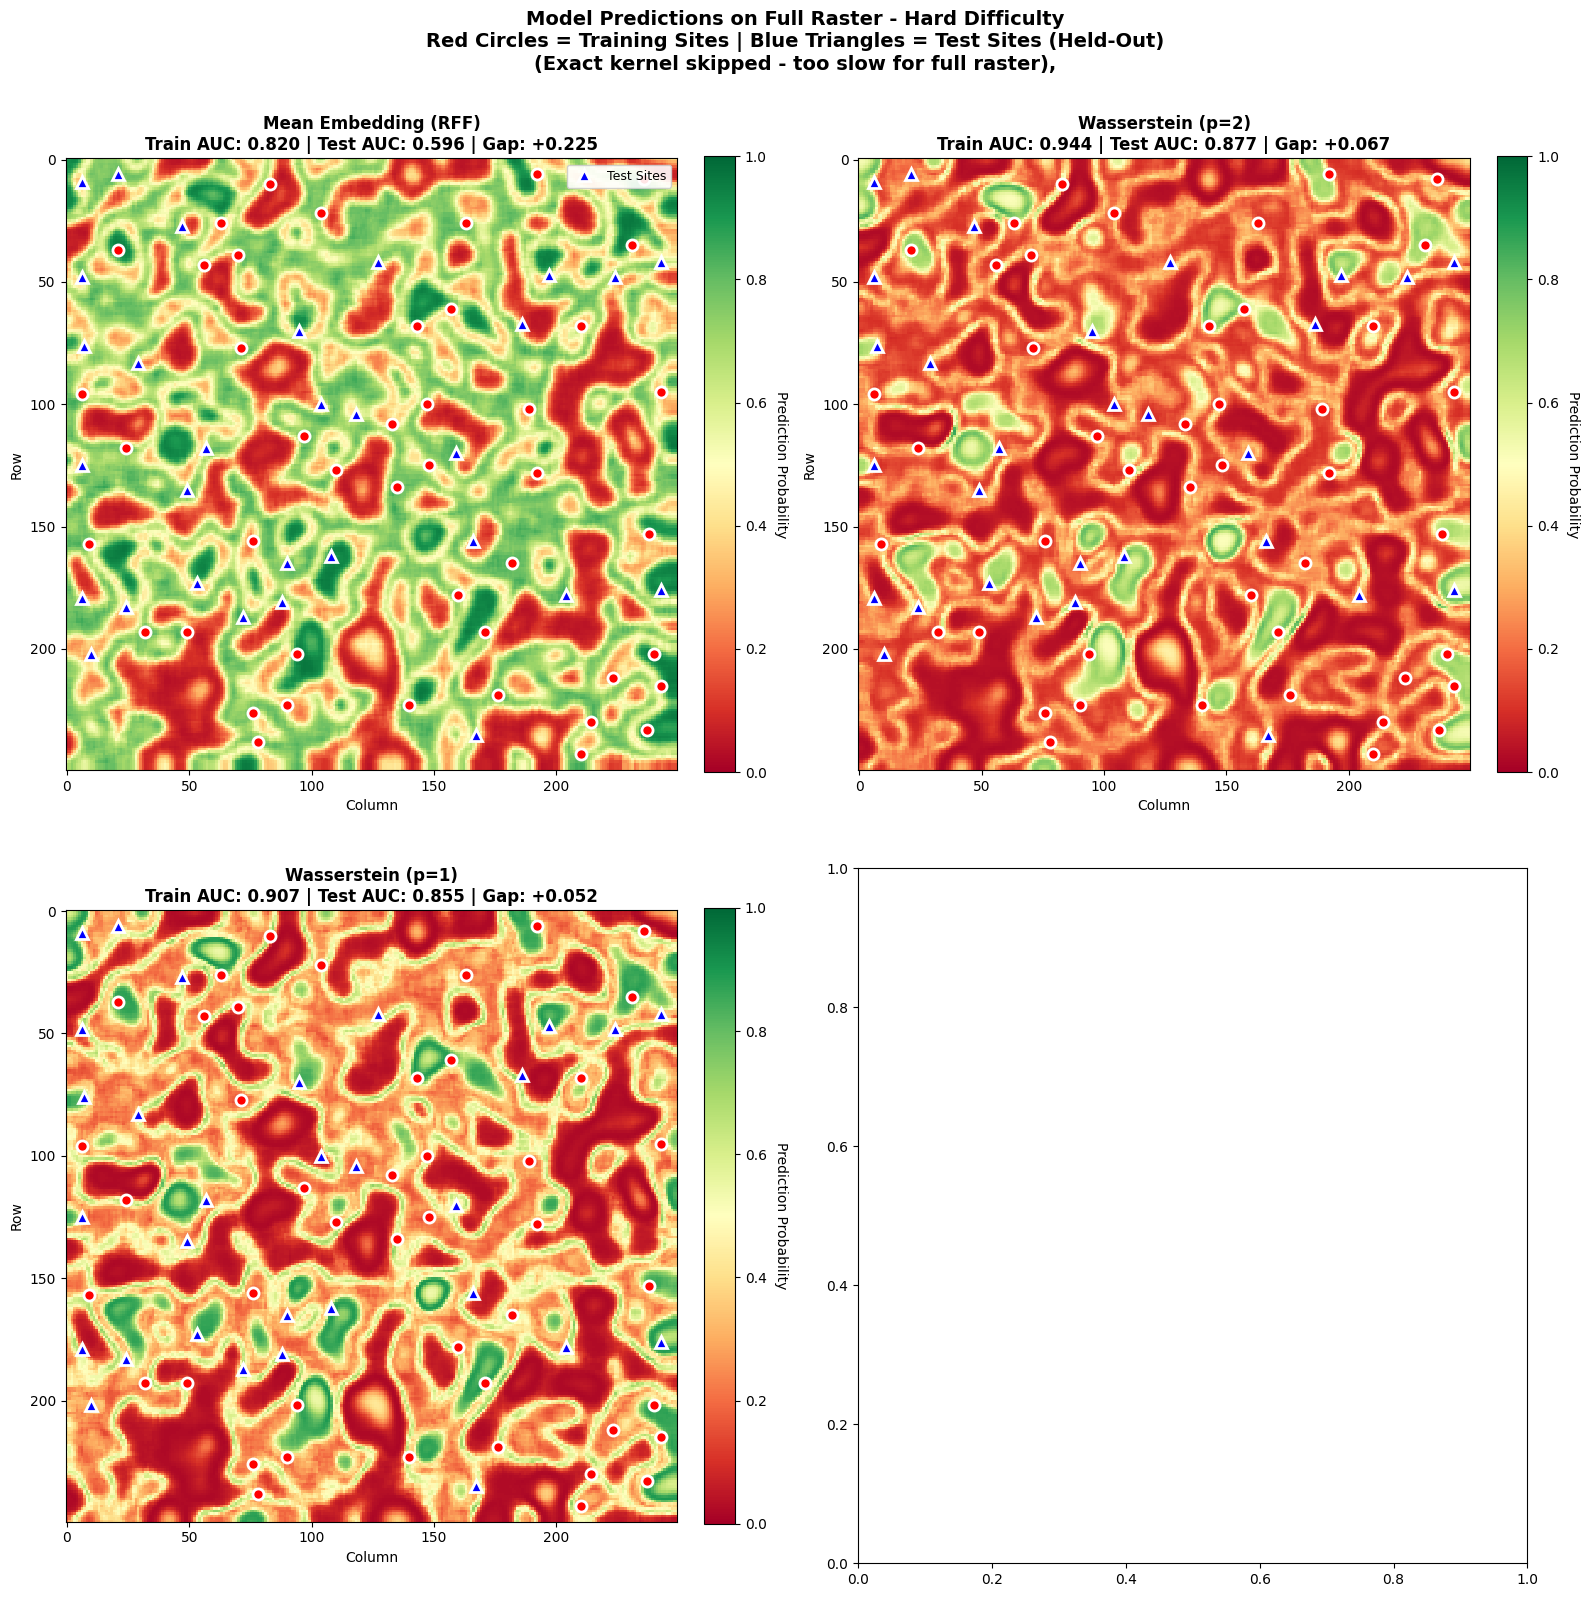


Prediction Map Summary:
Mean Embedding (RFF):
  Min: 0.0346, Max: 0.9674, Mean: 0.5083
  High probability (>0.7): 28.6% of pixels
Wasserstein (p=2):
  Min: 0.0201, Max: 0.8658, Mean: 0.2361
  High probability (>0.7): 2.6% of pixels
Wasserstein (p=1):
  Min: 0.0168, Max: 0.9098, Mean: 0.3263
  High probability (>0.7): 7.2% of pixels


In [14]:
# Create prediction maps for each kernel
n_models = len(KERNEL_CONFIGS)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

for idx, (name, predictions) in enumerate(raster_predictions.items()):
    ax = axes[idx]

    # Plot predictions
    im = ax.imshow(predictions, cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')

    # Overlay TRAINING sites (red circles)
    for _, row in train_sites_gdf.iterrows():
        row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
        ax.plot(col, row_idx, 'o', color='red', markersize=8,
               markeredgecolor='white', markeredgewidth=2,
               label='Training Sites' if _ == 0 else '')

    # Overlay TEST sites (blue triangles)
    for _, row in test_sites_gdf.iterrows():
        row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
        ax.plot(col, row_idx, '^', color='blue', markersize=8,
               markeredgecolor='white', markeredgewidth=2,
               label='Test Sites' if _ == 0 else '')

    # Get model performance
    result = kernel_results.get(name)
    if result:
        train_auc = result.train_auc
        test_auc = result.auc
        gap = train_auc - test_auc

        title = f'{name}\nTrain AUC: {train_auc:.3f} | Test AUC: {test_auc:.3f} | Gap: {gap:+.3f}'
    else:
        title = name

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column', fontsize=10)
    ax.set_ylabel('Row', fontsize=10)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Prediction Probability', rotation=270, labelpad=15, fontsize=10)

    # Add legend (only for first plot)
    if idx == 0:
        ax.legend(loc='upper right', fontsize=9, framealpha=0.9)

# Hide unused subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Model Predictions on Full Raster - {DIFFICULTY.capitalize()} Difficulty\n'
             f'Red Circles = Training Sites | Blue Triangles = Test Sites (Held-Out)\n'
             f'(Exact kernel skipped - too slow for full raster),',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print()
print("Prediction Map Summary:")
print("="*80)
for name, predictions in raster_predictions.items():
    pred_min = np.min(predictions)
    pred_max = np.max(predictions)
    pred_mean = np.mean(predictions)
    high_prob = np.sum(predictions > 0.7) / predictions.size * 100

    print(f"{name}:")
    print(f"  Min: {pred_min:.4f}, Max: {pred_max:.4f}, Mean: {pred_mean:.4f}")
    print(f"  High probability (>0.7): {high_prob:.1f}% of pixels")


BEST MODEL vs BASELINE COMPARISON
Best Kernel (with raster): Wasserstein (p=2) (Test AUC: 0.8773)



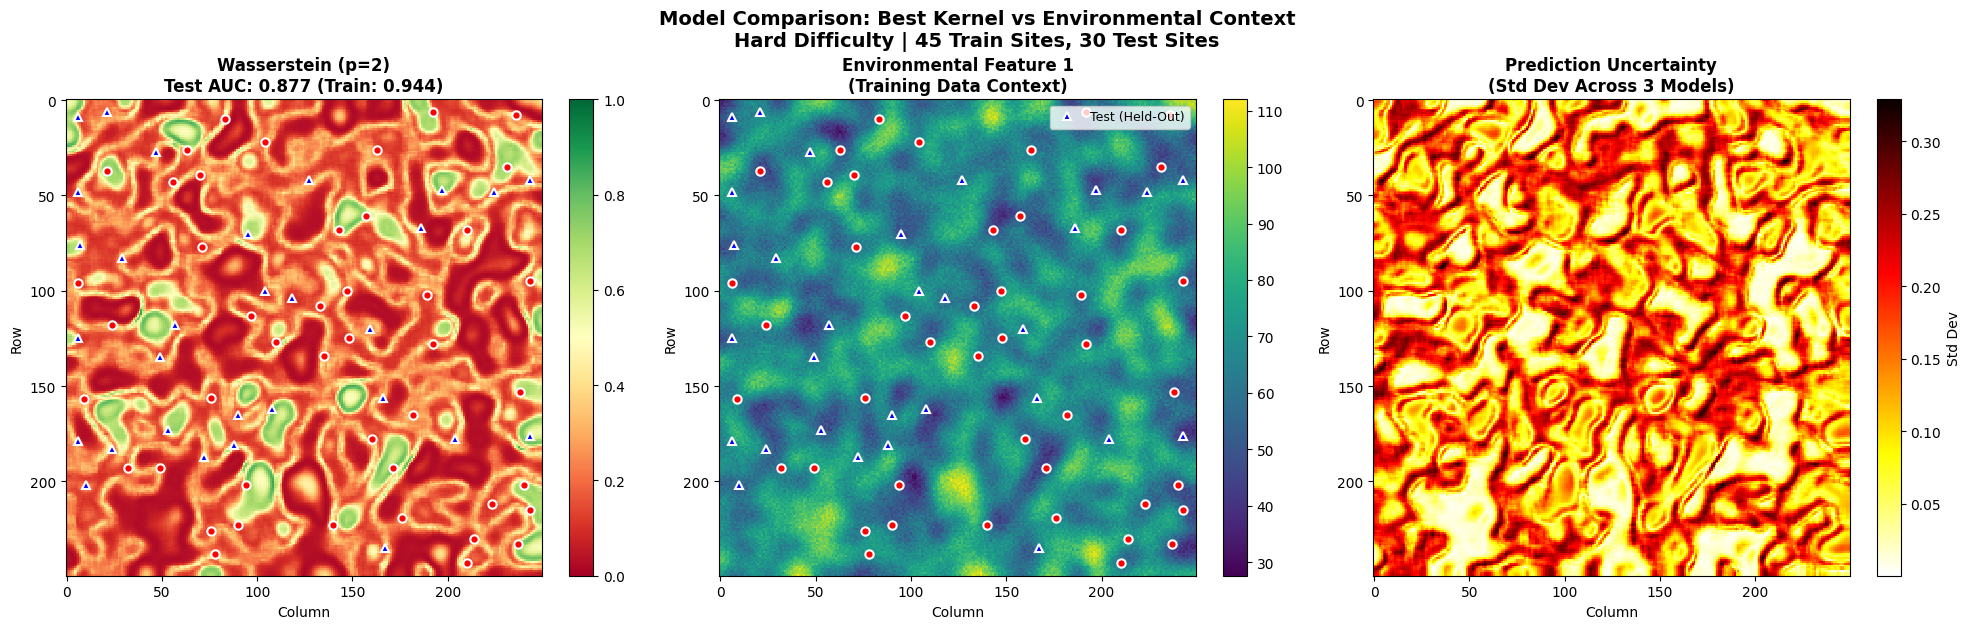


✓ Prediction maps generated successfully!
✓ Best model with raster predictions: Wasserstein (p=2)
✓ Train sites (red circles): 45
✓ Test sites (blue triangles): 30


In [15]:
# Compare best performing kernel vs logistic regression baseline
print()
print("="*80)
print("BEST MODEL vs BASELINE COMPARISON")
print("="*80)

# Find best kernel by test AUC from those with raster predictions
kernel_with_rasters = {k: v for k, v in kernel_results.items() 
                       if k in raster_predictions}
best_kernel_name = max(kernel_with_rasters.keys(), 
                       key=lambda k: kernel_with_rasters[k].auc)
best_kernel_result = kernel_with_rasters[best_kernel_name]

print(f"Best Kernel (with raster): {best_kernel_name} (Test AUC: {best_kernel_result.auc:.4f})")
print()

# Create side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Best Kernel
im0 = axes[0].imshow(raster_predictions[best_kernel_name], cmap='RdYlGn',
                    vmin=0, vmax=1, interpolation='nearest')

# Overlay sites
for _, row in train_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[0].plot(col, row_idx, 'o', color='red', markersize=6,
                markeredgecolor='white', markeredgewidth=1.5)

for _, row in test_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[0].plot(col, row_idx, '^', color='blue', markersize=6,
                markeredgecolor='white', markeredgewidth=1.5)

axes[0].set_title(f'{best_kernel_name}\nTest AUC: {best_kernel_result.auc:.3f} '
                 f'(Train: {best_kernel_result.train_auc:.3f})',
                 fontsize=12, fontweight='bold')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Plot 2: Feature 1 (for context)
im1 = axes[1].imshow(raster_stack.data[0], cmap='viridis', interpolation='nearest')

# Overlay sites
for _, row in train_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[1].plot(col, row_idx, 'o', color='red', markersize=6,
                markeredgecolor='white', markeredgewidth=1.5,
                label='Training' if _ == 0 else '')

for _, row in test_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[1].plot(col, row_idx, '^', color='blue', markersize=6,
                markeredgecolor='white', markeredgewidth=1.5,
                label='Test (Held-Out)' if _ == 0 else '')

axes[1].set_title('Environmental Feature 1\n(Training Data Context)',
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
axes[1].legend(loc='upper right', fontsize=9)
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Plot 3: Prediction uncertainty (variance across models with rasters)
all_preds = np.array([pred for pred in raster_predictions.values()])
pred_std = np.std(all_preds, axis=0)

im2 = axes[2].imshow(pred_std, cmap='hot_r', interpolation='nearest')
axes[2].set_title(f'Prediction Uncertainty\n(Std Dev Across {len(raster_predictions)} Models)',
                 fontsize=12, fontweight='bold')
axes[2].set_xlabel('Column')
axes[2].set_ylabel('Row')
plt.colorbar(im2, ax=axes[2], fraction=0.046, label='Std Dev')

plt.suptitle(f'Model Comparison: Best Kernel vs Environmental Context\n'
             f'{DIFFICULTY.capitalize()} Difficulty | {len(train_sites_gdf)} Train Sites, '
             f'{len(test_sites_gdf)} Test Sites',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print()
print("✓ Prediction maps generated successfully!")
print(f"✓ Best model with raster predictions: {best_kernel_name}")
print(f"✓ Train sites (red circles): {len(train_sites_gdf)}")
print(f"✓ Test sites (blue triangles): {len(test_sites_gdf)}")
print("="*80)

## 6. Visualizations

### 6.1 ROC Curves Comparison

Compare ROC curves for all models on the test set.

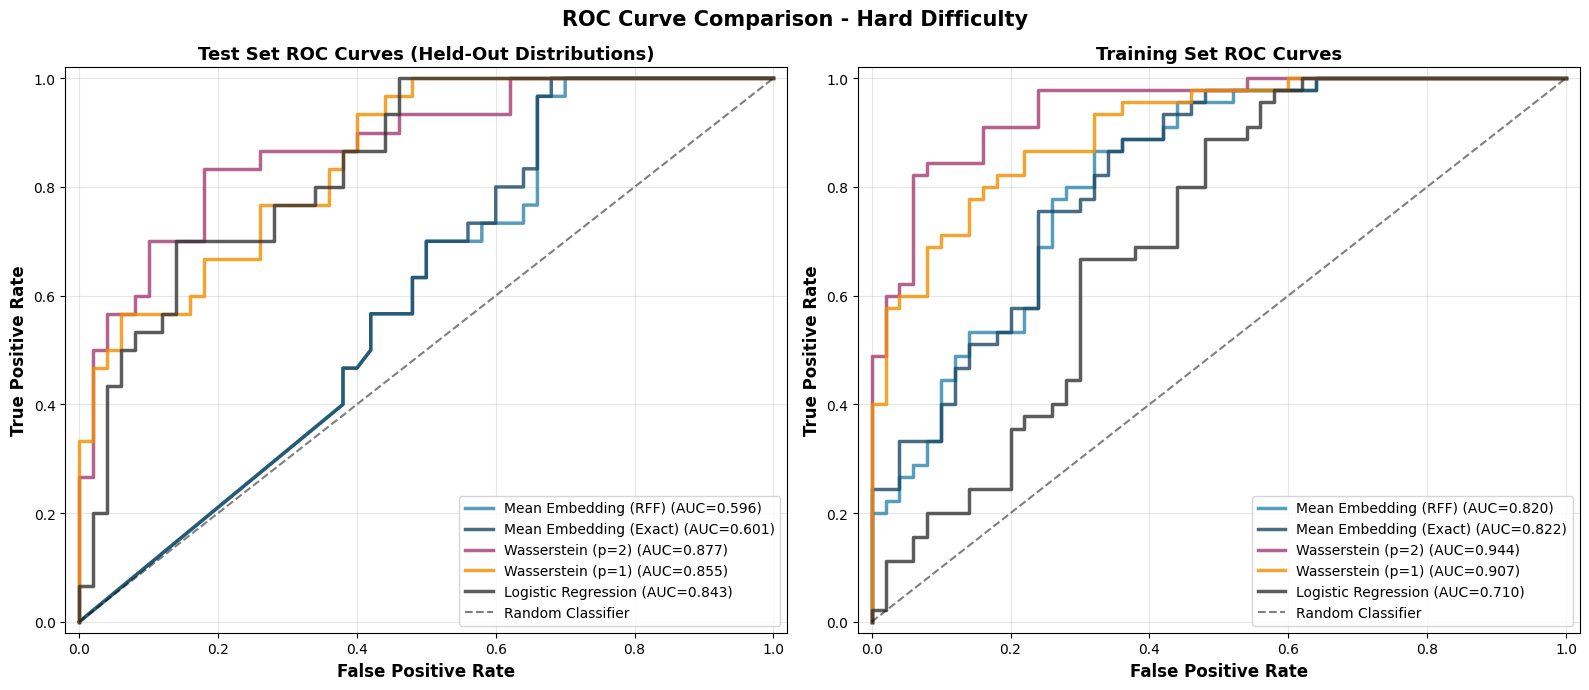


ROC Curve Statistics:
Mean Embedding (RFF):
  Test AUC:  0.5957
  Train AUC: 0.8204
  Gap:       +0.2248
Mean Embedding (Exact):
  Test AUC:  0.6010
  Train AUC: 0.8222
  Gap:       +0.2212
Wasserstein (p=2):
  Test AUC:  0.8773
  Train AUC: 0.9444
  Gap:       +0.0671
Wasserstein (p=1):
  Test AUC:  0.8547
  Train AUC: 0.9067
  Gap:       +0.0520
Logistic Regression:
  Test AUC:  0.8433
  Train AUC: 0.7102
  Gap:       -0.1331


In [16]:
# ROC Curves for all models (Test Set)
from sklearn.metrics import roc_curve, auc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Test Set ROC Curves
for name, result in kernel_results.items():
    # Compute ROC curve for test set
    fpr, tpr, _ = roc_curve(result.test_labels, result.test_predictions)
    color = KERNEL_CONFIGS.get(name, {}).get('color', '#333333')
    ax1.plot(fpr, tpr, label=f'{name} (AUC={result.auc:.3f})', 
             linewidth=2.5, color=color, alpha=0.8)

# Diagonal reference line
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('Test Set ROC Curves (Held-Out Distributions)', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-0.02, 1.02])
ax1.set_ylim([-0.02, 1.02])

# Right: Training Set ROC Curves
for name, result in kernel_results.items():
    # Compute ROC curve for training set
    fpr, tpr, _ = roc_curve(result.train_labels, result.train_predictions)
    color = KERNEL_CONFIGS.get(name, {}).get('color', '#333333')
    ax2.plot(fpr, tpr, label=f'{name} (AUC={result.train_auc:.3f})', 
             linewidth=2.5, color=color, alpha=0.8)

# Diagonal reference line
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax2.set_title('Training Set ROC Curves', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-0.02, 1.02])
ax2.set_ylim([-0.02, 1.02])

plt.suptitle(f'ROC Curve Comparison - {DIFFICULTY.capitalize()} Difficulty', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\nROC Curve Statistics:")
print("="*80)
for name, result in kernel_results.items():
    print(f"{name}:")
    print(f"  Test AUC:  {result.auc:.4f}")
    print(f"  Train AUC: {result.train_auc:.4f}")
    print(f"  Gap:       {result.train_auc - result.auc:+.4f}")

### 6.2 Geographic Overview - Train/Test Split

Visualize the spatial distribution of training and test sites.

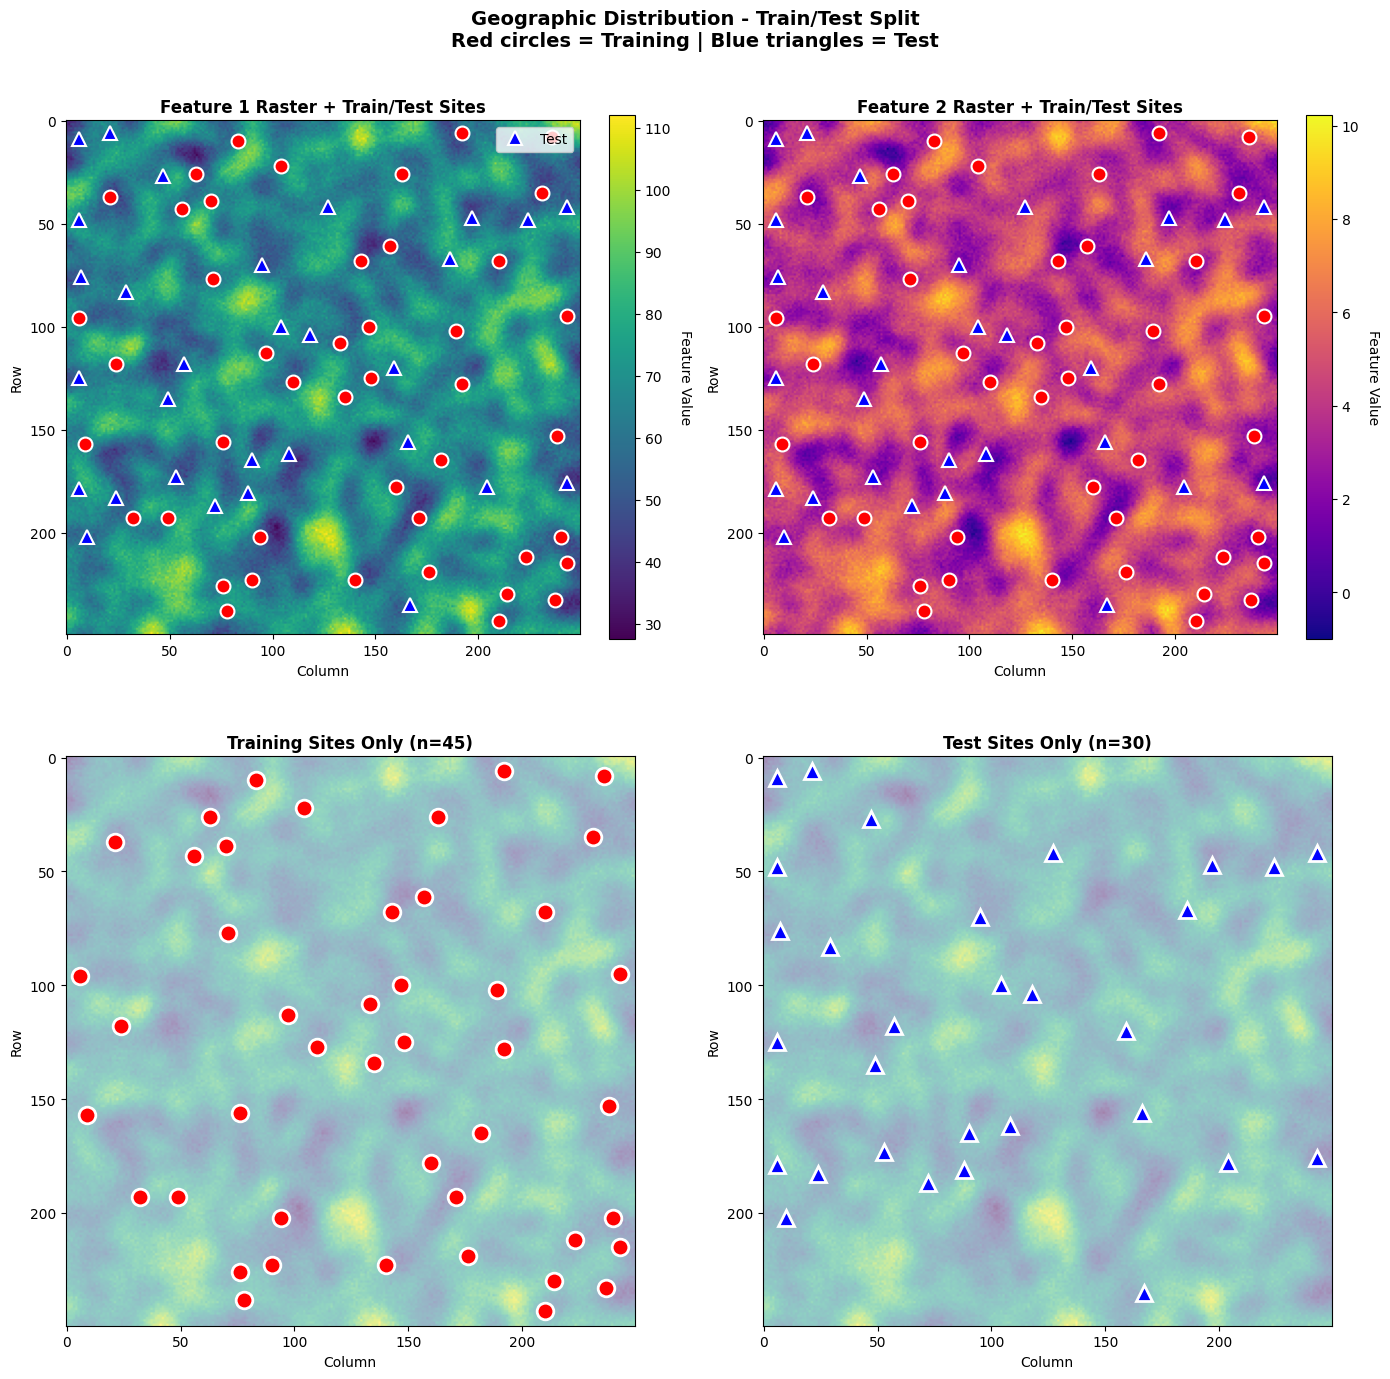


Train/Test Split Summary:
  Training sites: 45 (60%)
  Test sites: 30 (40%)
  Total sites: 75

✓ Test sites are completely held out - NO DATA LEAKAGE


In [17]:
# Visualize geographic distribution of train/test split
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Top-left: Feature 1 raster with ALL sites
axes[0, 0].imshow(raster_stack.data[0], cmap='viridis')
for _, row in train_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[0, 0].plot(col, row_idx, 'ro', markersize=10, markeredgecolor='white', 
                   markeredgewidth=1.5, label='Train' if _ == 0 else '')
for _, row in test_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[0, 0].plot(col, row_idx, 'b^', markersize=10, markeredgecolor='white', 
                   markeredgewidth=1.5, label='Test' if _ == 0 else '')
axes[0, 0].set_title(f'Feature 1 Raster + Train/Test Sites', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')
axes[0, 0].legend(loc='upper right', fontsize=10)
cbar = plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0], fraction=0.046)
cbar.set_label('Feature Value', rotation=270, labelpad=15)

# Top-right: Feature 2 raster with ALL sites
if raster_stack.n_bands > 1:
    axes[0, 1].imshow(raster_stack.data[1], cmap='plasma')
    for _, row in train_sites_gdf.iterrows():
        row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
        axes[0, 1].plot(col, row_idx, 'ro', markersize=10, markeredgecolor='white', 
                       markeredgewidth=1.5)
    for _, row in test_sites_gdf.iterrows():
        row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
        axes[0, 1].plot(col, row_idx, 'b^', markersize=10, markeredgecolor='white', 
                       markeredgewidth=1.5)
    axes[0, 1].set_title(f'Feature 2 Raster + Train/Test Sites', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Column')
    axes[0, 1].set_ylabel('Row')
    cbar = plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1], fraction=0.046)
    cbar.set_label('Feature Value', rotation=270, labelpad=15)
else:
    axes[0, 1].axis('off')

# Bottom-left: Training sites only
axes[1, 0].imshow(raster_stack.data[0], cmap='viridis', alpha=0.5)
for _, row in train_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[1, 0].plot(col, row_idx, 'ro', markersize=12, markeredgecolor='white', 
                   markeredgewidth=2)
axes[1, 0].set_title(f'Training Sites Only (n={len(train_sites_gdf)})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Column')
axes[1, 0].set_ylabel('Row')

# Bottom-right: Test sites only
axes[1, 1].imshow(raster_stack.data[0], cmap='viridis', alpha=0.5)
for _, row in test_sites_gdf.iterrows():
    row_idx, col = rasterio.transform.rowcol(transform, row.geometry.x, row.geometry.y)
    axes[1, 1].plot(col, row_idx, 'b^', markersize=12, markeredgecolor='white', 
                   markeredgewidth=2)
axes[1, 1].set_title(f'Test Sites Only (n={len(test_sites_gdf)})', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Row')

plt.suptitle(f'Geographic Distribution - Train/Test Split\nRed circles = Training | Blue triangles = Test', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\nTrain/Test Split Summary:")
print(f"  Training sites: {len(train_sites_gdf)} ({len(train_sites_gdf)/len(sites_gdf)*100:.0f}%)")
print(f"  Test sites: {len(test_sites_gdf)} ({len(test_sites_gdf)/len(sites_gdf)*100:.0f}%)")
print(f"  Total sites: {len(sites_gdf)}")
print(f"\n✓ Test sites are completely held out - NO DATA LEAKAGE")

### 6.3 Feature Space Analysis

Visualize distribution means in 2D feature space using PCA.

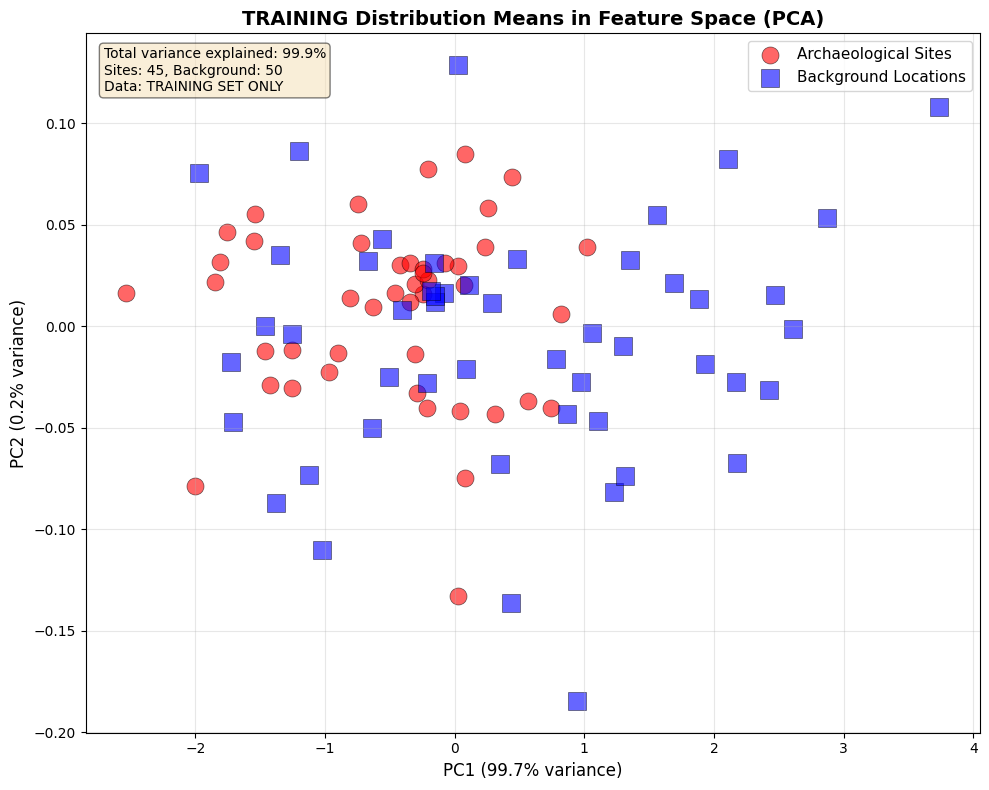


PCA Results (Training Data):
  PC1 explains 99.7% of variance
  PC2 explains 0.2% of variance
  Total: 99.9% captured in 2D
  Training distributions: 95


In [18]:
# PCA on TRAINING distribution means
means_array = np.array([np.mean(c.samples, axis=0) for c in train_data_scaled.collections])
labels_array = np.array([c.label for c in train_data_scaled.collections])

# Fit PCA
pca = PCA(n_components=2)
means_2d = pca.fit_transform(means_array)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Sites (label=1)
site_mask = labels_array == 1
ax.scatter(means_2d[site_mask, 0], means_2d[site_mask, 1],
           c='red', alpha=0.6, s=150, label='Archaeological Sites', 
           edgecolors='black', linewidths=0.5, marker='o')

# Background (label=0)
bg_mask = labels_array == 0
ax.scatter(means_2d[bg_mask, 0], means_2d[bg_mask, 1],
           c='blue', alpha=0.6, s=150, label='Background Locations', 
           edgecolors='black', linewidths=0.5, marker='s')

# Labels and formatting
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('TRAINING Distribution Means in Feature Space (PCA)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Add text with separation info
total_var = pca.explained_variance_ratio_[:2].sum()
ax.text(0.02, 0.98, f'Total variance explained: {total_var:.1%}\n'
                     f'Sites: {site_mask.sum()}, Background: {bg_mask.sum()}\n'
                     f'Data: TRAINING SET ONLY',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPCA Results (Training Data):")
print(f"  PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"  PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")
print(f"  Total: {total_var:.1%} captured in 2D")
print(f"  Training distributions: {len(train_data_scaled.collections)}")

### 6.4 Feature Distribution Comparison

Compare the distributions of feature values at sites vs. background locations.

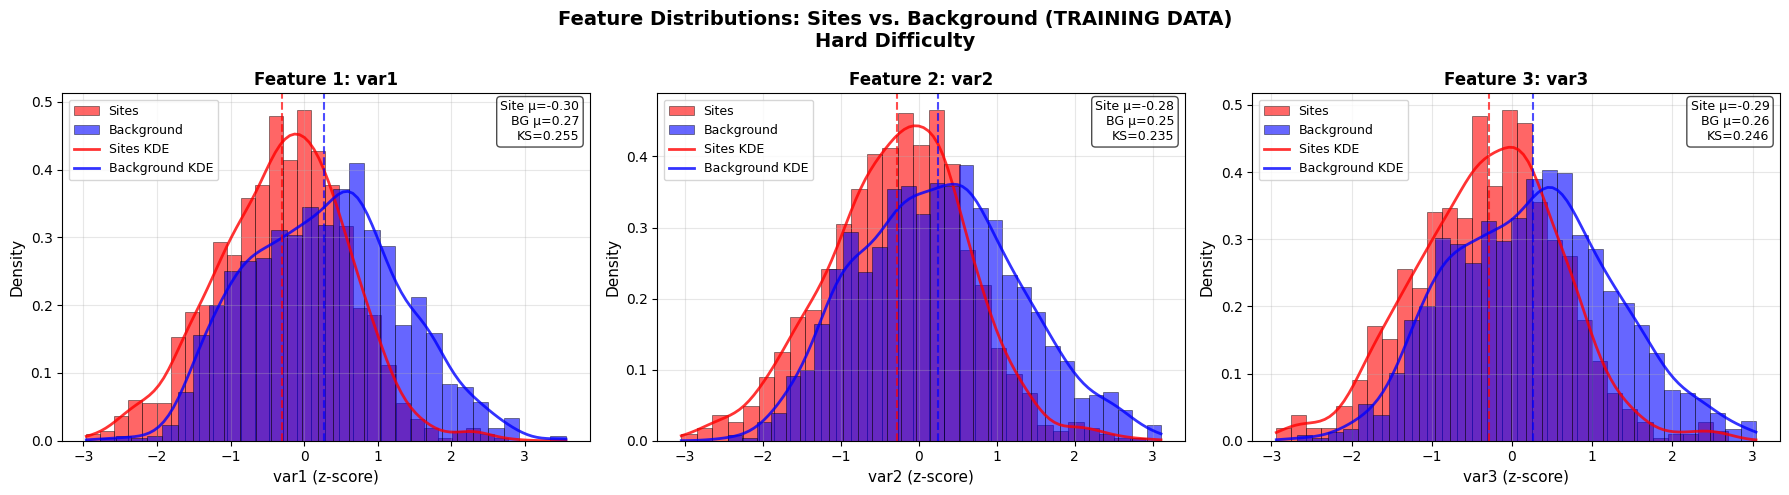


Distribution Statistics (Training Data):
  var1: Site μ=-0.299, BG μ=0.269, KS statistic=0.255 (p=0.0000)
  var2: Site μ=-0.276, BG μ=0.248, KS statistic=0.235 (p=0.0000)
  var3: Site μ=-0.287, BG μ=0.259, KS statistic=0.246 (p=0.0000)


In [19]:
# Extract all samples for sites and background from TRAINING data
n_features = train_data_scaled.collections[0].samples.shape[1]

site_samples = np.concatenate([
    np.array(c.samples) for c in train_data_scaled.collections if c.label == 1
])

bg_samples = np.concatenate([
    np.array(c.samples) for c in train_data_scaled.collections if c.label == 0
])

# Create subplot for each feature
fig, axes = plt.subplots(1, n_features, figsize=(6 * n_features, 5))
if n_features == 1:
    axes = [axes]

for feat_idx in range(n_features):
    ax = axes[feat_idx]
    
    # Extract feature values
    site_vals = site_samples[:, feat_idx]
    bg_vals = bg_samples[:, feat_idx]
    
    # Plot histograms
    ax.hist(site_vals, bins=30, alpha=0.6, label='Sites', color='red', 
            density=True, edgecolor='black', linewidth=0.5)
    ax.hist(bg_vals, bins=30, alpha=0.6, label='Background', color='blue', 
            density=True, edgecolor='black', linewidth=0.5)
    
    # Add KDE curves
    from scipy.stats import gaussian_kde
    if len(site_vals) > 1:
        kde_site = gaussian_kde(site_vals)
        x_range = np.linspace(min(site_vals.min(), bg_vals.min()), 
                             max(site_vals.max(), bg_vals.max()), 100)
        ax.plot(x_range, kde_site(x_range), 'r-', linewidth=2, alpha=0.8, label='Sites KDE')
    
    if len(bg_vals) > 1:
        kde_bg = gaussian_kde(bg_vals)
        x_range = np.linspace(min(site_vals.min(), bg_vals.min()), 
                             max(site_vals.max(), bg_vals.max()), 100)
        ax.plot(x_range, kde_bg(x_range), 'b-', linewidth=2, alpha=0.8, label='Background KDE')
    
    # Statistics
    site_mean = np.mean(site_vals)
    bg_mean = np.mean(bg_vals)
    ax.axvline(site_mean, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(bg_mean, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Labels and formatting
    ax.set_xlabel(f'{train_data_scaled.feature_names[feat_idx]} (z-score)', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Feature {feat_idx+1}: {train_data_scaled.feature_names[feat_idx]}', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add stats text
    from scipy.stats import ks_2samp
    ks_stat, ks_pval = ks_2samp(site_vals, bg_vals)
    stats_text = f'Site μ={site_mean:.2f}\nBG μ={bg_mean:.2f}\nKS={ks_stat:.3f}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle(f'Feature Distributions: Sites vs. Background (TRAINING DATA)\n{DIFFICULTY.capitalize()} Difficulty', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nDistribution Statistics (Training Data):")
for feat_idx in range(n_features):
    site_vals = site_samples[:, feat_idx]
    bg_vals = bg_samples[:, feat_idx]
    from scipy.stats import ks_2samp
    ks_stat, ks_pval = ks_2samp(site_vals, bg_vals)
    print(f"  {train_data_scaled.feature_names[feat_idx]}: Site μ={np.mean(site_vals):.3f}, "
          f"BG μ={np.mean(bg_vals):.3f}, KS statistic={ks_stat:.3f} (p={ks_pval:.4f})")